In [1]:
#Importing all necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fdist
import re
from matplotlib.dates import DateFormatter
from scipy.stats import ttest_ind

In [2]:
#Bringing in the data sets
transaction_data= pd.read_excel("QVI_transaction_data.xlsx")
customer_data = pd.read_csv('QVI_purchase_behaviour.csv')

In [3]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


#### Inspecting the  Transaction data

In [5]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [6]:
#he Date column has a wrong data type

#creating a function to converts an integer into date format

def date_fun(transactionDateInt):
    conversion = dt.datetime(1900, 1, 1)
    if(transactionDateInt < 60):
        No_of_days = dt.timedelta(days = (transactionDateInt - 1))
    else:
        No_of_days = dt.timedelta(days = (transactionDateInt - 2))
    Correct_date = conversion + No_of_days
    return Correct_date


In [7]:
#applying function to the date column
transaction_data['DATE'] = transaction_data['DATE'].apply(date_fun)

In [8]:
#Confirming that the data type has changed 
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.2+ MB


In [9]:
#confimring that the date is in a correct format
transaction_data['DATE'].head


<bound method NDFrame.head of 0        2018-10-17
1        2019-05-14
2        2019-05-20
3        2018-08-17
4        2018-08-18
            ...    
264831   2019-03-09
264832   2018-08-13
264833   2018-11-06
264834   2018-12-27
264835   2018-09-22
Name: DATE, Length: 264836, dtype: datetime64[ns]>

In [10]:
#Inspecting the Data set
#Checking for unique values in each column
transaction_data.nunique()

DATE                 364
STORE_NBR            272
LYLTY_CARD_NBR     72637
TXN_ID            263127
PROD_NBR             114
PROD_NAME            114
PROD_QTY               6
TOT_SALES            112
dtype: int64

The number of transaction IDs should be equal to the number of rows in the data set
It is expected that the transaction ID is generated for each purchase.
For this data set, there are 264,836 transactions but 263,127 Unique transaction IDs
suggesting that there are duplicates

In [11]:
#Checking for duplicates
transaction_data[transaction_data.duplicated(['TXN_ID'])]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
42,2019-05-20,55,55073,48887,113,Twisties Chicken270g,1,4.6
377,2019-01-10,7,7364,7739,20,Doritos Cheese Supreme 330g,2,11.4
419,2018-10-18,12,12301,10982,93,Doritos Corn Chip Southern Chicken 150g,2,7.8
476,2018-09-08,16,16427,14546,81,Pringles Original Crisps 134g,1,3.7
511,2018-08-03,19,19272,16683,31,Infzns Crn Crnchers Tangy Gcamole 110g,2,7.6
...,...,...,...,...,...,...,...,...
264287,2018-11-25,248,248085,250293,13,Red Rock Deli Thai Chilli&Lime 150g,2,5.4
264318,2019-04-23,248,248338,250624,106,Natural ChipCo Hony Soy Chckn175g,2,6.0
264528,2018-10-03,259,259038,257645,41,Doritos Salsa Mild 300g,2,5.2
264535,2018-09-04,259,259056,257775,19,Smiths Crinkle Cut Snag&Sauce 150g,2,5.2


There are 1709 entries in the dataset that are duplicate values

In [12]:
#Investigating the duplicates

transaction_data.loc[transaction_data["TXN_ID"] == 263823,[ 'DATE', 'PROD_NAME', 'STORE_NBR', 'TXN_ID', 'LYLTY_CARD_NBR'] ]


,DATE,PROD_NAME,STORE_NBR,TXN_ID,LYLTY_CARD_NBR
264693,2019-02-02,RRD Sweet Chilli & Sour Cream 165g,265,263823,265467
264694,2019-02-02,Thins Chips Light& Tangy 175g,265,263823,265467


Investigating transaction ID - 263823 shows that 2 transactions have the same ID,
which were done on the same day and at the same store.
This is an indication that the duplicate transactions are multiple purchases
made by the same customer and as such treated under the same transaction.

In [13]:
transaction_data['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

In [14]:
#Subsetting the pack weight from the product name

transaction_data['PACK_WEIGHT'] = transaction_data['PROD_NAME'].str.extract("(\d+)")
transaction_data['PACK_WEIGHT'] = (transaction_data['PACK_WEIGHT'])
transaction_data.head()

transaction_data['PROD_NAME']

0           Natural Chip        Compny SeaSalt175g
1                         CCs Nacho Cheese    175g
2           Smiths Crinkle Cut  Chips Chicken 170g
3           Smiths Chip Thinly  S/Cream&Onion 175g
4         Kettle Tortilla ChpsHny&Jlpno Chili 150g
                            ...                   
264831     Kettle Sweet Chilli And Sour Cream 175g
264832               Tostitos Splash Of  Lime 175g
264833                    Doritos Mexicana    170g
264834     Doritos Corn Chip Mexican Jalapeno 150g
264835               Tostitos Splash Of  Lime 175g
Name: PROD_NAME, Length: 264836, dtype: object

In [19]:
# Creating a function to remove digits and special characters from the  PROD_NAME feature
def clean_ProdName(text):
    text = re.sub('\d\w*', ' ', text) # remove the digits and the weight unit(g)
    text = re.sub('[&/]', ' ', text) # to remove special characters '&' and '/'
    return text


In [27]:
transaction_data['PROD_NAME'] = transaction_data['PROD_NAME'].apply(clean_ProdName)

In [28]:
transaction_data['PROD_NAME']

0           Natural Chip        Compny SeaSalt 
1                         CCs Nacho Cheese     
2           Smiths Crinkle Cut  Chips Chicken  
3           Smiths Chip Thinly  S Cream Onion  
4         Kettle Tortilla ChpsHny Jlpno Chili  
                          ...                  
264831     Kettle Sweet Chilli And Sour Cream  
264832               Tostitos Splash Of  Lime  
264833                    Doritos Mexicana     
264834     Doritos Corn Chip Mexican Jalapeno  
264835               Tostitos Splash Of  Lime  
Name: PROD_NAME, Length: 264836, dtype: object

In [31]:
#### looking at the most common words by counting the number of times the word appears and
#### sorting them by this frequency in order of highest to lowest frequency

# Combining all contents of the Prod_Name column for ease of 
#counting the number of occurence of each word in the column

All_Prod_Name = word_tokenize(''.join(transaction_data['PROD_NAME']))


In [34]:
#using the fdist function to find the frequency of each word and displaying  it in a data frame 
wordFrequency = fdist(prodWord)
Prod_Name_freq = pd.DataFrame(list(wordFrequency.items()), columns = ["Word", "Frequency"]).sort_values(by = 'Frequency', ascending = False)

In [35]:
Prod_Name_freq.head()

,Word,Frequency
10,Chips,49770
16,Kettle,40739
7,Smiths,28572
6,Cheese,27890
66,Pringles,24743


In [36]:
#### Removing salsa products

transaction_data['PROD_NAME'] = transaction_data['PROD_NAME'].apply(lambda x: x.lower())
transaction_data = transaction_data[~transaction_data['PROD_NAME'].str.contains("salsa")]
transaction_data['PROD_NAME'] = transaction_data['PROD_NAME'].apply(lambda x: x.title())

In [37]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150


In [38]:
#Checking for missing values in the entire dataset
transaction_data.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
PACK_WEIGHT       0
dtype: int64

In [41]:
#Summary Statistics of the data set

transaction_data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [ ]:
#There appears to be something off with the Prod_qty column as 
#the maximum value varies massively from other statistics

In [43]:
#Investigating further
transaction_data['PROD_QTY'].value_counts()

2      220070
1       25476
5         415
3         408
4         371
200         2
Name: PROD_QTY, dtype: int64

In [46]:
#There appears to be 2 outliers - 2 transactions with quantity of 200 
# a very wide difference from the usual range of about 2
transaction_data.loc[transaction_data['PROD_QTY'] == 200, :]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


In [48]:
#Thes transactions were done by the same customer at the same store location, 
#they apparently bought 200 Dorito corn Chip supreme each time

#Checking if customer had other transactions to understand thier pattern
transaction_data.loc[transaction_data['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


In [50]:

#It looks like this customer has only had the two transactions over the year and is
#not an ordinary retail customer. The customer might be buying chips for commercial
#purposes instead. 

#removing this loyalty card number from the data sets to exclude it from further analysis

transaction_data.drop(transaction_data.index[transaction_data['LYLTY_CARD_NBR'] == 226000], inplace = True)
customer_data.drop(customer_data.index[customer_data['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [51]:
#Confirming the changes
transaction_data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
std,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


In [52]:
transaction_data['PROD_QTY'].value_counts()

2    220070
1     25476
5       415
3       408
4       371
Name: PROD_QTY, dtype: int64

In [54]:
#looking at the number of transaction lines over time to see
#if there are any obvious data issues such as missing data.

#### Count the number of transactions by date
transaction_data['DATE'].nunique()

364

In [ ]:
#There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
#create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
#chart of number of transactions over time to find the missing date.

In [62]:
#creating a sequence of dates from 1 Jul 2018 to 30 Jun 2019 (Adding a transaction count column)
B = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
B['No_of_Transactions'] = 0

B.head()


,No_of_Transactions
2018-07-01,0
2018-07-02,0
2018-07-03,0
2018-07-04,0
2018-07-05,0


In [68]:
#Creating a similar table but from the transaction data
A = pd.pivot_table(transaction_data, values = 'TOT_SALES', index = 'DATE', aggfunc = 'count')
A = A.rename(columns = {'TOT_SALES':'No_of_Transactions'})
A.head()

,No_of_Transactions
DATE,
2018-07-01,663
2018-07-02,650
2018-07-03,674
2018-07-04,669
2018-07-05,660


In [69]:
#Merging both tables
C = A + B
C.fillna(0, inplace = True)

In [70]:
#Since there will be no transaction on the missing data, checking the date with 0 transactions
C[C['No_of_Transactions'] == 0]

,No_of_Transactions
2018-12-25,0.0


In [72]:
#There was no transaction on the 25th of December which is the missing date.


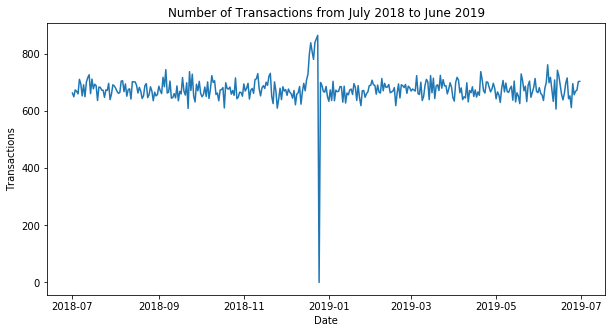

In [73]:
timeline = C.index
graph = C['No_of_Transactions']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Number of Transactions from July 2018 to June 2019')
plt.xlabel('Date')
plt.ylabel('Transactions')

plt.show()

In [75]:
#We can see that there is an increase in purchases in December before the massive drop on Christmas Day
## Zooming into December only

C_december = C[(C.index < "2019-01-01") & (C.index > "2018-11-30")]
C_december.head()

,No_of_Transactions
2018-12-01,675.0
2018-12-02,655.0
2018-12-03,677.0
2018-12-04,666.0
2018-12-05,660.0


Text(0.5, 1.0, 'Daily Transactions in December')

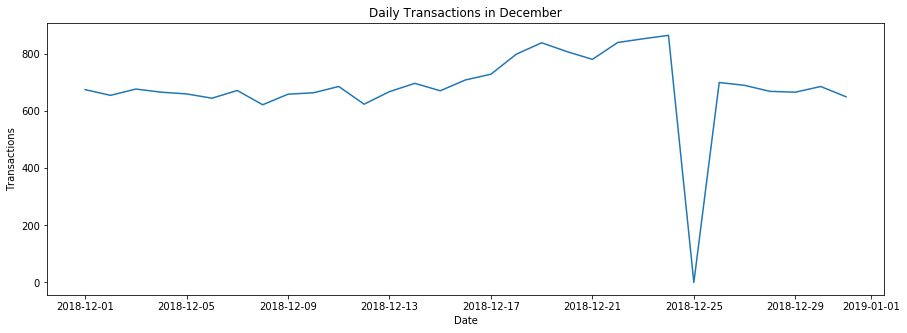

In [76]:
#Plotting a graph for december only
plt.figure(figsize = (15, 5))
plt.plot(C_december)
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.title('Daily Transactions in December')

In [ ]:
#We can see that the increase in sales occurs in the lead-up to Christmas and that
#there are zero sales on Christmas day itself. This is due to shops being closed on
#Christmas day.

In [78]:
#Creating the Pack size from the product name ---which we had already done and named pack weight
Pack_Size = transaction_data['PACK_WEIGHT']

In [ ]:
Pack_Size.describe()

In [83]:
#The Pack Size appears to not be numeric, changing the data type to numeric

Pack_Size = pd.to_numeric(Pack_Size)

#confirming the data type
Pack_Size.describe()

count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: PACK_WEIGHT, dtype: float64

In [ ]:
#The largest size is 380g and the smallest size is 70g - seems sensible!

Text(0.5, 1.0, 'Pack Size Histogram')

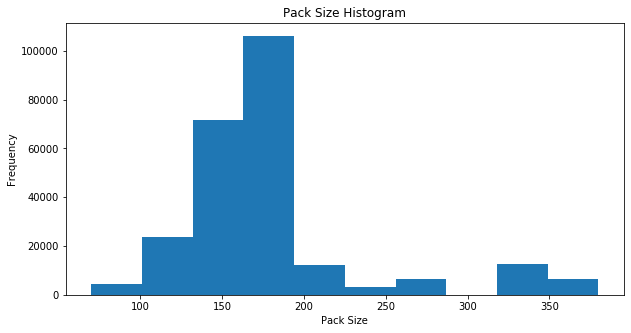

In [84]:
#Ploting a histogram showing the number of transactions by pack size.

plt.figure(figsize = (10, 5))
plt.hist(Pack_Size)     
plt.xlabel('Pack Size')
plt.ylabel('Frequency')
plt.title('Pack Size Histogram')

In [ ]:
#Most frequently purchased pack size is in the 175g range.

In [85]:
###BRANDS
#Using the first word of the PROD_NAME to work out the brand
# Extract brand name from PROD_NAME and create new column called BRAND

part = transaction_data['PROD_NAME'].str.partition()
transaction_data['BRAND'] = part[0]
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,Ccs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150,Kettle


In [86]:
transaction_data['BRAND'].unique()

array(['Natural', 'Ccs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'Ww', 'Thins', 'Burger', 'Ncc', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'Grnwves',
       'Tyrrells', 'Cobs', 'French', 'Rrd', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [87]:
#Renaming Brand Names for Consistency

transaction_data['BRAND'].replace('Ncc', 'Natural', inplace = True)
transaction_data['BRAND'].replace('Ccs', 'CCS', inplace = True)
transaction_data['BRAND'].replace('Smith', 'Smiths', inplace = True)
transaction_data['BRAND'].replace(['Grain', 'Grnwves'], 'Grainwaves', inplace = True)
transaction_data['BRAND'].replace('Dorito', 'Doritos', inplace = True)
transaction_data['BRAND'].replace('Ww', 'Woolworths', inplace = True)
transaction_data['BRAND'].replace('Infzns', 'Infuzions', inplace = True)
transaction_data['BRAND'].replace(['Red', 'Rrd'], 'Red Rock Deli', inplace = True)
transaction_data['BRAND'].replace('Snbts', 'Sunbites', inplace = True)

In [89]:
#Confirming the changes
transaction_data['BRAND'].unique()

array(['Natural', 'CCS', 'Smiths', 'Kettle', 'Grainwaves', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

#### Inspecting the Customer data

In [91]:
customer_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [92]:
#Checking for missing values
customer_data.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [94]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72636 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72636 non-null  int64 
 1   LIFESTAGE         72636 non-null  object
 2   PREMIUM_CUSTOMER  72636 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [96]:
#checking the distribution of the LIFESTAGE and PREMIUM_CUSTOMER columns
customer_data['LIFESTAGE'].nunique()

7

In [98]:
customer_data['PREMIUM_CUSTOMER'].nunique()

3

In [99]:
customer_data['LIFESTAGE'].value_counts().sort_values(ascending = False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

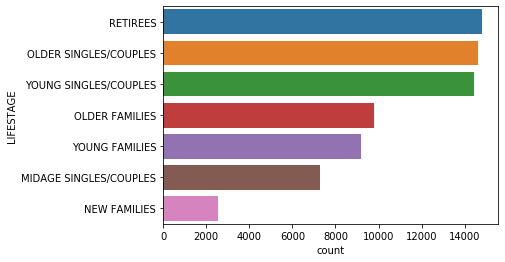

In [102]:
sns.countplot(y = customer_data['LIFESTAGE'], order = customer_data['LIFESTAGE'].value_counts().index)

In [ ]:
#The top 3 Life stages where the customers fall into is the Retirees Life stage,
#followed by the Older Singles/Couples and then young singles/couples.

In [103]:
customer_data['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending = False)

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

Text(0, 0.5, 'Premium Customer')

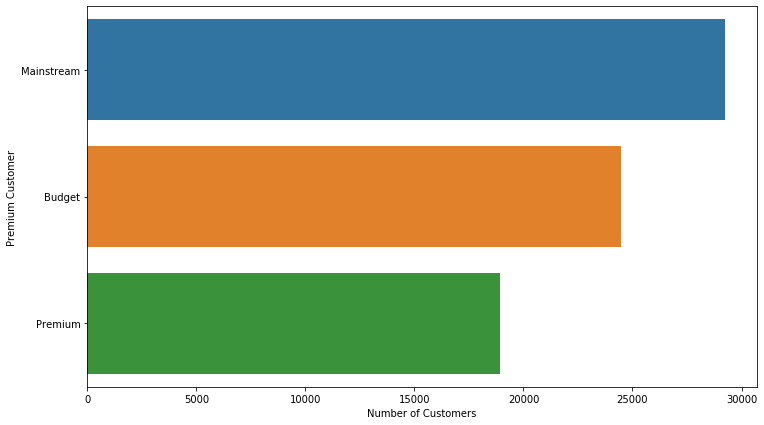

In [104]:
plt.figure(figsize = (12, 7))
sns.countplot(y = customer_data['PREMIUM_CUSTOMER'], order = customer_data['PREMIUM_CUSTOMER'].value_counts().index)
plt.xlabel('Number of Customers')
plt.ylabel('Premium Customer')

In [105]:
# Merging the transaction_data and customer_data together

combined_data = pd.merge(transaction_data, customer_data)

In [106]:
#Checking the new data set
combined_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCS,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


In [107]:
#checking for missing values
combined_data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_WEIGHT         0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [109]:
#checking the shape to confirm that there are no duplicates.
print("Transaction data shape: ", transaction_data.shape)
print("Customer data shape: ", customer_data.shape)
print("Combined data shape: ", combined_data.shape)

Transaction data shape:  (246740, 10)
Customer data shape:  (72636, 3)
Combined data shape:  (246740, 12)


In [ ]:
#The number of entries in the combined data corresponds with the transaction data 
#which means there are no duplicates

In [110]:
#Saving the clean dataset for further analysis
combined_data.to_csv("CombinedDataTask1.csv")

### Data Analysis on Customer Segments

Now that the data is ready for analysis, we can define some metrics of interest:

- Who spends the most on chips (total sales), describing customers by lifestage and
how premium their general purchasing behaviour is

- How many customers are in each segment

- How many chips are bought per customer by segment

- What's the average chip price by customer segment

We could also ask our data team for more information. Examples are:
- The customer's total spend over the period and total spend for each transaction
to understand what proportion of their grocery spend is on chips
- Proportion of customers in each customer segment overall to compare against the
mix of customers who purchase chips

In [ ]:
#### Total sales by LIFESTAGE and PREMIUM_CUSTOMER

In [111]:
sales = pd.DataFrame(combined_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum())
sales.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales.sort_values(by = 'Total Sales', ascending = False, inplace = True)
sales

Total Sales
PREMIUM_CUSTOMER LIFESTAGE                          
Budget           OLDER FAMILIES            156863.75
Mainstream       YOUNG SINGLES/COUPLES     147582.20
                 RETIREES                  145168.95
Budget           YOUNG FAMILIES            129717.95
                 OLDER SINGLES/COUPLES     127833.60
Mainstream       OLDER SINGLES/COUPLES     124648.50
Premium          OLDER SINGLES/COUPLES     123537.55
Budget           RETIREES                  105916.30
Mainstream       OLDER FAMILIES             96413.55
Premium          RETIREES                   91296.65
Mainstream       YOUNG FAMILIES             86338.25
                 MIDAGE SINGLES/COUPLES     84734.25
Premium          YOUNG FAMILIES             78571.70
                 OLDER FAMILIES             75242.60
Budget           YOUNG SINGLES/COUPLES      57122.10
Premium          MIDAGE SINGLES/COUPLES     54443.85
                 YOUNG SINGLES/COUPLES      39052.30
Budget           MIDAGE SINGLES/COUPLES     33345.70
                 NEW FAMILIES               20607.45
Mainstream       NEW FAMILIES               15979.70
Premium          NEW FAMILIES               10760.80

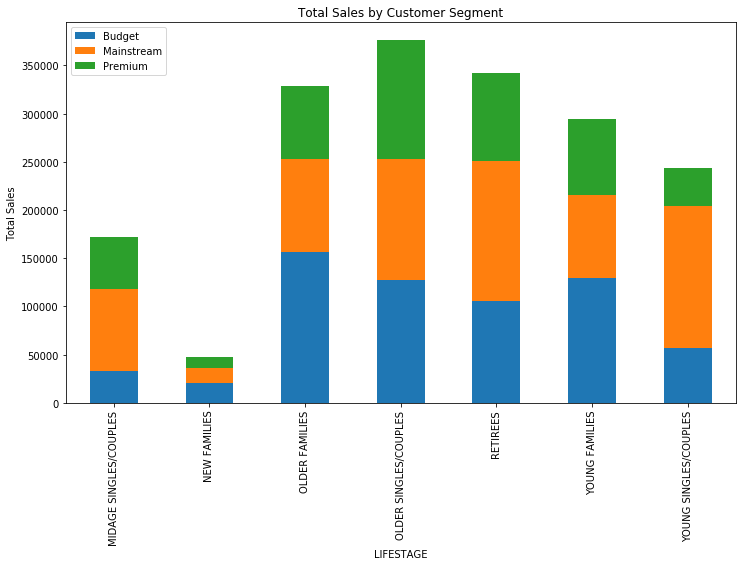

In [112]:
salesPlot = pd.DataFrame(combined_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum())
salesPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Total Sales by Customer Segment')
plt.ylabel('Total Sales')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

Budget - Older Families spent the most on chips.
Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees

In [113]:
#### Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
customers = pd.DataFrame(combined_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customers.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
customers.sort_values(by = 'Number of Customers', ascending = False).head(10)

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                 
Mainstream       YOUNG SINGLES/COUPLES                 7917
                 RETIREES                              6358
                 OLDER SINGLES/COUPLES                 4858
Budget           OLDER SINGLES/COUPLES                 4849
Premium          OLDER SINGLES/COUPLES                 4682
Budget           OLDER FAMILIES                        4611
                 RETIREES                              4385
                 YOUNG FAMILIES                        3953
Premium          RETIREES                              3812
Budget           YOUNG SINGLES/COUPLES                 3647

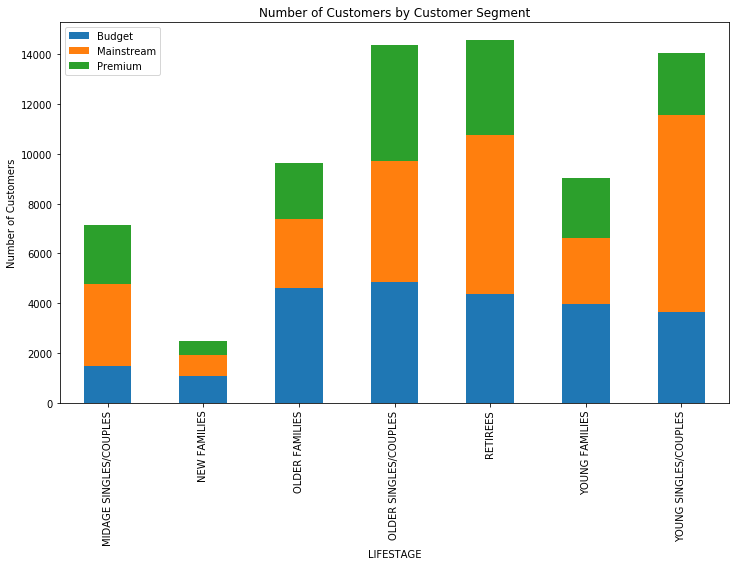

In [114]:
customersPlot = pd.DataFrame(combined_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
customersPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Number of Customers by Customer Segment')
plt.ylabel('Number of Customers')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

There are more Mainstream - young singles/couples and Mainstream - retirees who buy
chips. This contributes to there being more sales to these customer segments but
this is not a major driver for the Budget - Older families segment.

Higher sales may also be driven by more units of chips being bought per customer.

In [116]:
# Average number of  units per customer by PREMIUM_CUSTOMER and LIFESTAGE

avg_units = combined_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / combined_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_units = pd.DataFrame(avg_units, columns = {'Average Unit per Customer'})
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,9.255380
Budget,OLDER FAMILIES,9.076773
Premium,OLDER FAMILIES,9.071717
Budget,YOUNG FAMILIES,8.722995
Premium,YOUNG FAMILIES,8.716013


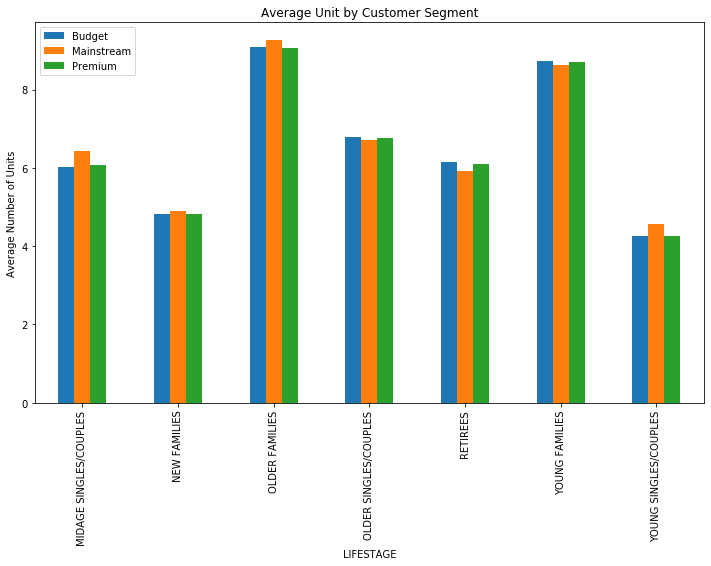

In [117]:
avgUnitsPlot = pd.DataFrame(combined_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum() / combined_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
avgUnitsPlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Unit by Customer Segment')
plt.ylabel('Average Number of Units')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

Older families and young families in general buy more chips per customer
Let's also investigate the average price per unit chips bought for each customer
segment as this is also a driver of total sales.

In [119]:
# Average price per unit by PREMIUM_CUSTOMER and LIFESTAGE

avg_price = combined_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum() / combined_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price.sort_values(by = 'Price per Unit', ascending = False).head()

Price per Unit
PREMIUM_CUSTOMER LIFESTAGE                             
Mainstream       YOUNG SINGLES/COUPLES         4.074043
                 MIDAGE SINGLES/COUPLES        3.994449
                 NEW FAMILIES                  3.935887
Budget           RETIREES                      3.932731
                 NEW FAMILIES                  3.931969

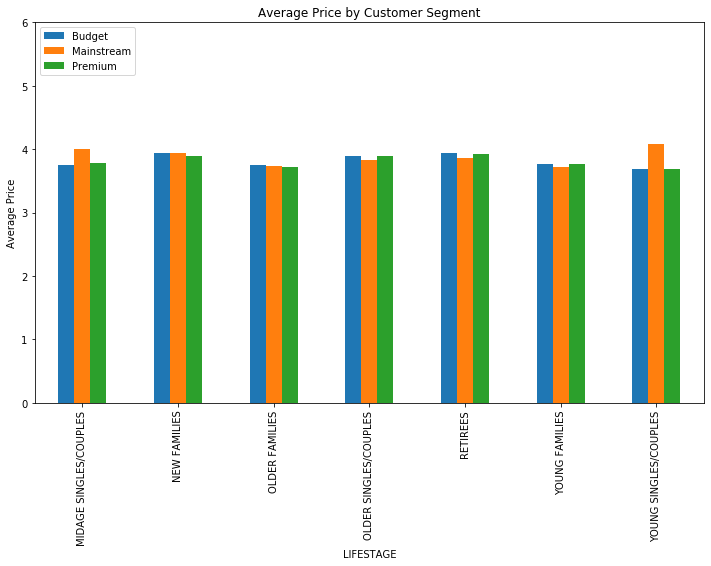

In [120]:
avgPricePlot = pd.DataFrame(combined_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum() / combined_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum())
avgPricePlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Price by Customer Segment', ylim = (0, 6))
plt.ylabel('Average Price')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

Mainstream midage and young singles and couples are more willing to pay more per
packet of chips compared to their budget and premium counterparts. This may be due
to premium shoppers being more likely to buy healthy snacks and when they buy
chips, this is mainly for entertainment purposes rather than their own consumption.
This is also supported by there being fewer premium midage and young singles and
couples buying chips compared to their mainstream counterparts.

In [122]:
# Performing an independent t-test between mainstream vs non-mainstream midage and young singles/couples 
#to test this difference statistically

# Create a new dataframe pricePerUnit
pricePerUnit = combined_data

# Create a new column under pricePerUnit called PRICE
pricePerUnit['PRICE'] = pricePerUnit['TOT_SALES'] / pricePerUnit['PROD_QTY']


pricePerUnit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget,1.90
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45


In [123]:
# Grouping the  data into mainstream and non-mainstream

mainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
nonMainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']

In [126]:
# Performing a  t-test 

ttest_ind(mainstream, nonMainstream)

Ttest_indResult(statistic=37.83196107667825, pvalue=2.235645611540966e-309)

The t-test results in a p-value of 2.235645611540966e-309, which shows that the unit price for mainstream, young and mid-age singles and couples is significantly higher than
that of budget or premium, young and midage singles and couples.

Deep dive into specific customer segments for insights
We have found quite a few interesting insights that we can dive deeper into.
We might want to target customer segments that contribute the most to sales to
retain them or further increase sales. Let's look at Mainstream - young
singles/couples. For instance, let's find out if they tend to buy a particular
brand of chips.

In [189]:
#Since we are interested in the mainstream young singles/couples, subsetting the data set into 
#mainstream - young singles/couples and non-mainstream young singles/couples
target = combined_data.loc[(combined_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (combined_data['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
nonTarget = combined_data.loc[(combined_data['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (combined_data['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
target.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
221345,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag Sauce,1,2.6,150,Smiths,YOUNG SINGLES/COUPLES,Mainstream,2.6
221346,2018-10-02,1,1020,27,7,Smiths Crinkle Original,1,5.7,330,Smiths,YOUNG SINGLES/COUPLES,Mainstream,5.7
221347,2019-05-02,1,1020,28,84,Grnwves Plus Btroot Chilli Jam,1,3.1,180,Grainwaves,YOUNG SINGLES/COUPLES,Mainstream,3.1
221348,2018-08-17,1,1163,188,46,Kettle Original,1,5.4,175,Kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
221349,2019-02-07,1,1163,189,12,Natural Chip Co Tmato Hrb Spce,1,3.0,175,Natural,YOUNG SINGLES/COUPLES,Mainstream,3.0


In [ ]:
####Affinity to Brand

In [179]:
# Target Segment
targetBrand = target.loc[:, ['BRAND', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())

# Non-target segment
nonTargetBrand = nonTarget.loc[:, ['BRAND', 'PROD_QTY']]
nonTargetSum = nonTargetBrand['PROD_QTY'].sum()
nonTargetBrand['Non-Target Brand Affinity'] = nonTargetBrand['PROD_QTY'] / nonTargetSum
nonTargetBrand = pd.DataFrame(nonTargetBrand.groupby('BRAND')['Non-Target Brand Affinity'].sum())

In [180]:
# Merge the two dataframes together

brand_proportions = pd.merge(targetBrand, nonTargetBrand, left_index = True, right_index = True)
brand_proportions.head()

,Target Brand Affinity,Non-Target Brand Affinity
BRAND,,
Burger,0.002926,0.006538
CCS,0.011180,0.018445
Cheetos,0.008033,0.011759
Cheezels,0.017971,0.018904
Cobs,0.044638,0.038449


In [181]:
brand_proportions['Affinity to Brand'] = brand_proportions['Target Brand Affinity'] / brand_proportions['Non-Target Brand Affinity']
brand_proportions.sort_values(by = 'Affinity to Brand', ascending = False)

,Target Brand Affinity,Non-Target Brand Affinity,Affinity to Brand
BRAND,,,
Tyrrells,0.031553,0.025715,1.227025
Twisties,0.046184,0.037933,1.217506
Doritos,0.122761,0.101171,1.213397
Kettle,0.197985,0.166560,1.188667
Tostitos,0.045411,0.038350,1.184100
Pringles,0.119420,0.101110,1.181090
Cobs,0.044638,0.038449,1.160959
Infuzions,0.064679,0.057410,1.126622
Thins,0.060373,0.057159,1.056217


Mainstream young singles/couples are more likely to purchase Tyrrells chips.

#### Affinity to pack size

In [202]:
target.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
221345,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag Sauce,1,2.6,150,Smiths,YOUNG SINGLES/COUPLES,Mainstream,2.6
221346,2018-10-02,1,1020,27,7,Smiths Crinkle Original,1,5.7,330,Smiths,YOUNG SINGLES/COUPLES,Mainstream,5.7
221347,2019-05-02,1,1020,28,84,Grnwves Plus Btroot Chilli Jam,1,3.1,180,Grainwaves,YOUNG SINGLES/COUPLES,Mainstream,3.1
221348,2018-08-17,1,1163,188,46,Kettle Original,1,5.4,175,Kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
221349,2019-02-07,1,1163,189,12,Natural Chip Co Tmato Hrb Spce,1,3.0,175,Natural,YOUNG SINGLES/COUPLES,Mainstream,3.0


,PACK_WEIGHT,PROD_QTY
221345,150,1
221346,330,1
221347,180,1
221348,175,1
221349,175,1


In [208]:
# Target segment 
targetSize = target[['PACK_WEIGHT', 'PROD_QTY']]
targetSum = targetSize['PROD_QTY'].sum()
targetSize['Target Pack Affinity'] = targetSize['PROD_QTY'] / targetSum
targetSize = pd.DataFrame(targetSize.groupby('PACK_WEIGHT')['Target Pack Affinity'].sum())

# Non-target segment
nonTargetSize = nonTarget[['PACK_WEIGHT', 'PROD_QTY']]
nonTargetSum = nonTargetSize['PROD_QTY'].sum()
nonTargetSize['Non-Target Pack Affinity'] = nonTargetSize['PROD_QTY'] / nonTargetSum
nonTargetSize = pd.DataFrame(nonTargetSize.groupby('PACK_WEIGHT')['Non-Target Pack Affinity'].sum())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [209]:
# Merge the two dataframes together

pack_proportions = pd.merge(targetSize, nonTargetSize, left_index = True, right_index = True)
pack_proportions.head()

,Target Pack Affinity,Non-Target Pack Affinity
PACK_WEIGHT,,
110,0.106280,0.089575
125,0.003009,0.005976
134,0.119420,0.101110
135,0.014769,0.012931
150,0.157598,0.163070


In [210]:

pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity'] / pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by = 'Affinity to Pack', ascending = False)

,Target Pack Affinity,Non-Target Pack Affinity,Affinity to Pack
PACK_WEIGHT,,,
270,0.031829,0.025070,1.269608
380,0.032160,0.025711,1.250827
330,0.061284,0.050974,1.202243
110,0.106280,0.089575,1.186492
134,0.119420,0.101110,1.181090
210,0.029124,0.024891,1.170020
135,0.014769,0.012931,1.142086
250,0.014355,0.012863,1.115959
170,0.080773,0.080347,1.005300


### Conclusion



Budget-Older families, Mainstream-Young Singles/Couples, and Mainstream Retirees contribute the most to Total sales.

There are more Mainstream-Young Singles/Couples and Mainstream-Retirees customers, which explains their huge contribution to  Total sales.

Although there arent many Budget-Older families, their high frequency of purchase is the reason why they contribute more to Total Sales.

175g pack sized chips are the most purchased.

Mainstream-Young Singles/Couples aren't really deterred by high prices and seem more interested in 270g pack sizes and Tyrells chips